# Reconnaissance faciale via $k$ plus proches voisins ($k$-NN)

>## Partie 1: Dataset

## Librairies

- La librairie `cv2` permet la détection automatique de visages, entre autres.

- La librairie `pickle` permet de sauvegarder vos modèles une fois entraînés, et de les recharger pour pouvoir les utiliser.

In [ ]:
import os

import cv2
import pickle

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

## Création du dataset

Le code suivant permet de créer un **dataset** d'images que vous utiliserez dans votre projet de **reconnaissance faciale**. Ce dataset contiendra des images de vous-même associées à votre nom ainsi que des images d'autres personnes (par exemple vos camarades) associées à leurs noms. **À chaque fois que vos relancez le code ci-dessous, votre caméra capture 10 images de la personne qui se trouve devant vootre PC et ajoute ces dernières à votre dataset.**

Le code effectue les opérations suivantes. Premièrement, on lit le flux vidéo de votre caméra et on détecte automatiquement les visages dans chaque image de ce flux en utilisant le **classificateur en cascade de Haar (Haar cascade classifier)** de la librairie `OpenCV`.

Plus précisément, tant que la variable `ret` est vraie, indiquant que le flux vidéo est lu correctement, pour chaque image capturée par la caméras, on effectue les opérations suivantes:
1. on convertit l'image en niveaux de gris;
2. on détecte les coordonnées du visage en utilisant le classificateur en cascade de Haar;
3. on recadre la région du visage et la redimensionne en $50 \times 50$ pixels;
4. on ajoute l'image du visage redimensionné à la liste `donnees_visage`, à chaque intervalle de $10$ images.

Une fois que $10$ images de votre visage ont été collecteés, ou si l'utilisateur appuye sur la touche `Esc`, on met fin à la boucle et enregistre les images dans la liste `donnees_visage` sous forme d'un tableau `NumPy`.

Par la suite, l'existence des fichiers `noms.pkl` et `visages.pkl` est vérifiée. S'ils n'existent pas, de nouveaux fichiers sont créés, la variable `nom` est enregistrée dans `noms.pkl` et les données de visage sont enregistrées dans `visages.pkl`. Si ces fichiers existent déjà, le code charge les données existantes, ajoute les nouvelles données de visage et noms, et les réenregistre le tout dans ces fichiers.

In [ ]:
# ================== #
# Variables globales #
# ================== #

# Création d'un répertoire data
if not os.path.exists("data"):
    os.mkdir("data")

nb_images_collectees = 10 # Nombre d'image qu'on veut collecter

donnees_visage = [] # Liste vide pour stocker les visages

# =============================== #
# Capture des data: nom et images #
# =============================== #

# Définition de la fonction pour capturer une photo
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button'); // bouton pour capture d'image
      capture.textContent = 'Capture';
      div.appendChild(capture);
      // permet l'affichage du flux vidéo de notre caméra en temps réel
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      // l'exécution du script s'interromp jusqu'à ce qu'un clic pour la capture soit effectué
      await new Promise((resolve) => capture.onclick = resolve);
      // capture de l'image, arrêt de la caméra, mise en format jpeg de l'image
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  # On exécute le script JavaScript et on réceptionne l'image capturée sous forme de chaîne de données base64
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  # on décode la chaîne base64 pour obtenir les données de l'image en binaire
  binary = b64decode(data.split(',')[1])
  # Sauvegarde des données binaires dans un fichier image
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# on charge le modèl qui permet de détecter les visage
cascade_visage = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

nom = input("Entrez votre nom: ")  # pour saisire le nom
for i in range(nb_images_collectees):
    filename = take_photo()  # Capture une photo
    image = cv2.imread(filename)
    gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coordonnees_visage = cascade_visage.detectMultiScale(gris, 1.3, 5)

    for (x, y, w, h) in coordonnees_visage:
        visage = image[y:y+h, x:x+w]
        visage_redimensionne = cv2.resize(visage, (50, 50))
        donnees_visage.append(visage_redimensionne)
        break  # on sauvegarde que le 1er visage détecté

# Conversion en un tableau numpy
donnees_visage = np.array(donnees_visage)

# Enregistrement des noms
noms_path = "data/noms.pkl"
if os.path.exists(noms_path):
    with open(noms_path, 'rb') as file:
        noms = pickle.load(file)
else:
    noms = []

noms += [nom] * nb_images_collectees
with open(noms_path, 'wb') as file:
    pickle.dump(noms, file)

# Enregistrement des visages
visages_path = "data/visages.pkl"
if os.path.exists(visages_path):
    with open(visages_path, 'rb') as file:
        visages_existants = pickle.load(file)
    visages = np.concatenate((visages_existants, donnees_visage), axis=0)
else:
    visages = donnees_visage

with open(visages_path, 'wb') as file:
    pickle.dump(visages, file)

Entrez votre nom: rihanna


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualisation du dataset

Le instructions suivantes permettent de loader votre dataset et de comprendre comment sont stockées les data.

Prêtez attention aux types de vos data, en particulier à la dimension de vos images, etc.

In [ ]:
with open("data/noms.pkl", "rb") as fh:
    noms = pickle.load(fh)

In [ ]:
noms

['rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna',
 'rihanna']

In [ ]:
with open("data/visages.pkl", "rb") as fh:
    visages = pickle.load(fh)

In [ ]:
visages

array([[[[255, 250, 238],
         [252, 252, 248],
         [255, 255, 255],
         ...,
         [ 16,   4,   0],
         [ 15,   2,   0],
         [ 19,   2,   0]],

        [[255, 254, 245],
         [253, 255, 255],
         [253, 255, 255],
         ...,
         [ 16,   4,   0],
         [ 16,   4,   0],
         [ 18,   2,   0]],

        [[255, 255, 249],
         [254, 255, 253],
         [255, 255, 255],
         ...,
         [ 15,   4,   0],
         [ 19,   3,   0],
         [ 16,   4,   0]],

        ...,

        [[ 22,   2,   0],
         [ 25,   4,   0],
         [ 29,   7,   2],
         ...,
         [ 43,  16,   2],
         [ 39,  16,   1],
         [ 41,  14,   1]],

        [[ 23,   2,   1],
         [ 25,   3,   1],
         [ 29,   4,   0],
         ...,
         [ 37,  11,   0],
         [ 37,  14,   0],
         [ 37,  11,   0]],

        [[ 23,   5,   0],
         [ 25,   6,   0],
         [ 28,   8,   1],
         ...,
         [ 35,  12,   1],
        

In [ ]:
visages.shape

(30, 50, 50, 3)

In [ ]:
sample_1 = visages[0]
sample_1.shape

(50, 50, 3)

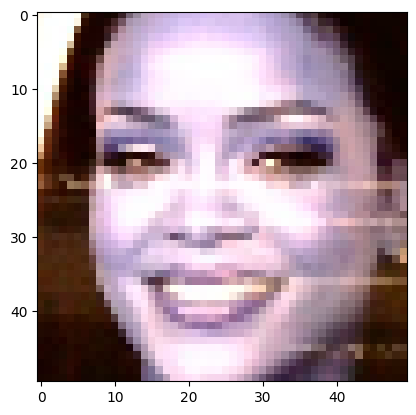

In [ ]:
plt.imshow(sample_1, interpolation="nearest")

In [ ]:
sample_2 = visages[5]
sample_2.shape

(50, 50, 3)

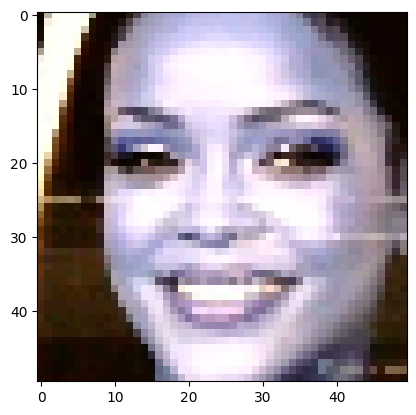

In [ ]:
plt.imshow(sample_2, interpolation="nearest")